In [1]:
# Обработка отзывов о мобильных телефонах

In [2]:
## Установка библиотек

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from catboost import EFstrType
from sklearn.pipeline import Pipeline
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymystem3 import Mystem
mystem_analyzer = Mystem()
import re


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from string import punctuation
from collections import Counter
from tqdm import tqdm
from pymorphy3 import MorphAnalyzer

from transformers import AutoModelForSeq2SeqLM, T5TokenizerFast

## Константы

In [5]:
LOCAL_PATH = 'D:/_DS/Edu/NLP_1_flow/data/'
RANDOM_STATE = RS = 654321
TEST_SIZE = .25
# выделение в тексте
BOLD = "\033[1m"
ITALIC = "\033[3m"
END = "\033[0m"
CR = '\n'

## Вспомогательные функции

In [6]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print (BOLD + 'Изучим исходные данные' + END)
    print(data.info())
    print(BOLD + CR + f'Вывод первых {size} строк датафрейма:' + END)
    display(data.head(size))
    print(BOLD + CR + 'Вывод основной информации о датафрейме:' + END)
    print(CR + 'Количество строк: ', data.shape[0])
    print('Количество столбцов: ', data.shape[1])
    categ_col = data.columns[data.dtypes == 'object']
    num_col = data.columns[data.dtypes != 'object']
    print('Количество категориальных признаков: ', len(categ_col))
    print('Количество числовых признаков: ', len(num_col))
    missed_cells = data.isna().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isna().sum(axis = 1)>0)/data.shape[0]
    print (BOLD + CR + 'Проверка пропусков'+ END)
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ END)
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
    print(BOLD +  CR + 'Описание количественных данных:'+ END)
    display(pd.concat([pd.DataFrame(np.array([data[num_col].isna().sum(), data[num_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[num_col].columns), data.describe().T], axis=1))
    print(BOLD + CR + 'Описание категориальных данных:'+ '\033[0m')
    display(pd.concat([pd.DataFrame(np.array([data[categ_col].isna().sum(), data[categ_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[categ_col].columns), data.describe(include='object').T], axis=1))
    ## Проверим дубликаты
    print (BOLD +  CR + 'Проверка на дубликаты'+ END)
    print('Количество полных дубликатов: ', data.duplicated().sum())
        

In [7]:
with open(LOCAL_PATH + 'jigsaw-toxic-comment-train-google-ru.csv', 'r', encoding='utf-8')as f:
    comments_text = f.read()

In [8]:
comments_text[:1500]

',id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate\n0,000103f0d9cfb60f,"D\'Оо! Он соответствует этому цвету фона, с которым я, похоже, застрял. Спасибо. (разговор) 21:51, 11 января 2016 г. (UTC)",0,0,0,0,0,0\n1,00025465d4725e87,"""\n\nПоздравляю и меня, хорошо использую инструменты. · разговаривать """,0,0,0,0,0,0\n2,0009801bd85e5806,"Смысл Mitsurugi не имеет смысла - почему бы не поспорить, чтобы включить хинди на страницу Рио Саказаки, чтобы включить больше информации?",0,0,0,0,0,0\n3,00070ef96486d6f9,"О, и девушка выше начала свои споры со мной. Она сунула нос туда, где он не принадлежит. Я считаю, что спор был между мной и Ивесниммо. Но, как я уже сказал, ситуация была урегулирована, и я извинился. Спасибо,",0,0,0,0,0,0\n4,0007e25b2121310b,"До свидания!\nНе смотри, приходи или думай о возвращении! Tosser.",1,0,0,0,0,0\n5,001735f961a23fc4,"""\n\xa0Конечно, но ведущая должна кратко подвести итог истории Армении. Я просто добавил то, что счел необходимым. Если кт

In [9]:
data = pd.read_csv(LOCAL_PATH + 'jigsaw-toxic-comment-train-google-ru.csv', sep=',')

In [10]:
data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,000103f0d9cfb60f,"D'Оо! Он соответствует этому цвету фона, с кот...",0,0,0,0,0,0
1,1,00025465d4725e87,"""\n\nПоздравляю и меня, хорошо использую инстр...",0,0,0,0,0,0
2,2,0009801bd85e5806,Смысл Mitsurugi не имеет смысла - почему бы не...,0,0,0,0,0,0
3,3,00070ef96486d6f9,"О, и девушка выше начала свои споры со мной. О...",0,0,0,0,0,0
4,4,0007e25b2121310b,"До свидания!\nНе смотри, приходи или думай о в...",1,0,0,0,0,0


In [11]:
about_df(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     223549 non-null  int64 
 1   id             223549 non-null  object
 2   comment_text   223147 non-null  object
 3   toxic          223549 non-null  object
 4   severe_toxic   223549 non-null  int64 
 5   obscene        223549 non-null  int64 
 6   threat         223549 non-null  int64 
 7   insult         223549 non-null  int64 
 8   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 15.4+ MB
None

Вывод первых 5 строк датафрейма:


,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,000103f0d9cfb60f,"D'Оо! Он соответствует этому цвету фона, с кот...",0,0,0,0,0,0
1,1,00025465d4725e87,"""\n\nПоздравляю и меня, хорошо использую инстр...",0,0,0,0,0,0
2,2,0009801bd85e5806,Смысл Mitsurugi не имеет смысла - почему бы не...,0,0,0,0,0,0
3,3,00070ef96486d6f9,"О, и девушка выше начала свои споры со мной. О...",0,0,0,0,0,0
4,4,0007e25b2121310b,"До свидания!\nНе смотри, приходи или думай о в...",1,0,0,0,0,0



Вывод основной информации о датафрейме:

Количество строк:  223549
Количество столбцов:  9
Количество категориальных признаков:  3
Количество числовых признаков:  6

Проверка пропусков
Количество пропусков: 402
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.2%

Описание количественных данных:


,кол-во пропусков,"доля пропусков, %",count,mean,std,min,25%,50%,75%,max
Unnamed: 0,0.0,0.0,223549.0,111774.000000,64533.182001,0.0,55887.0,111774.0,167661.0,223548.0
severe_toxic,0.0,0.0,223549.0,0.008777,0.093272,0.0,0.0,0.0,0.0,1.0
obscene,0.0,0.0,223549.0,0.054306,0.226621,0.0,0.0,0.0,0.0,1.0
threat,0.0,0.0,223549.0,0.003082,0.055431,0.0,0.0,0.0,0.0,1.0
insult,0.0,0.0,223549.0,0.050566,0.219110,0.0,0.0,0.0,0.0,1.0
identity_hate,0.0,0.0,223549.0,0.009470,0.096852,0.0,0.0,0.0,0.0,1.0



Описание категориальных данных:


,кол-во пропусков,"доля пропусков, %",count,unique,top,freq
id,0.0,0.000000,223549,223549,000103f0d9cfb60f,1
comment_text,402.0,0.179826,223147,222917,ПЕРЕСМОТРЕННАЯ ИНФОРМАЦИЯ,10
toxic,0.0,0.000000,223549,3,0,201785



Проверка на дубликаты
Количество полных дубликатов:  0


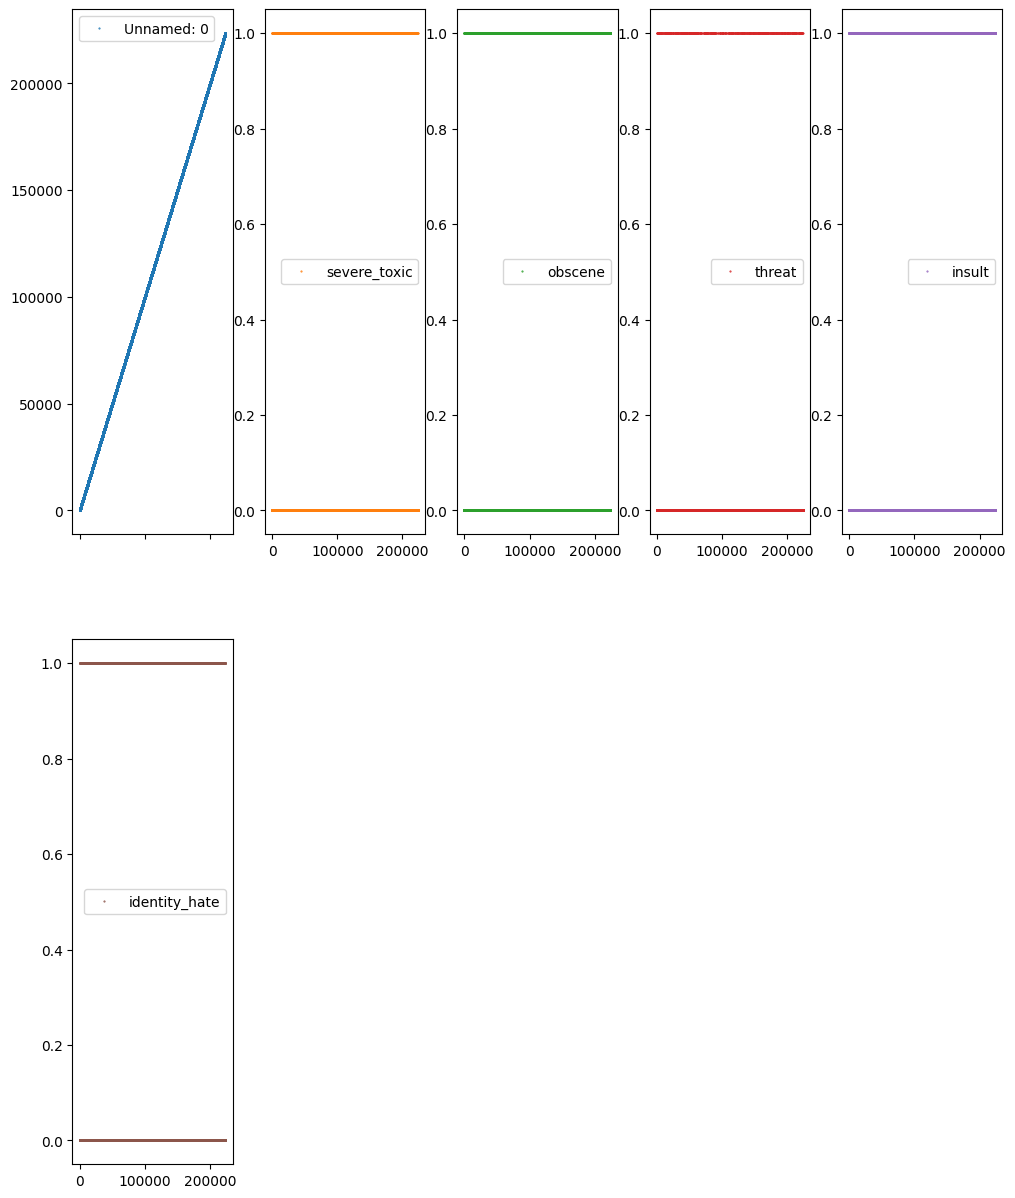

In [12]:
data.plot(
    lw=0, marker=".", subplots=True, layout=(-1, 5), figsize=(12, 15), markersize=1
);

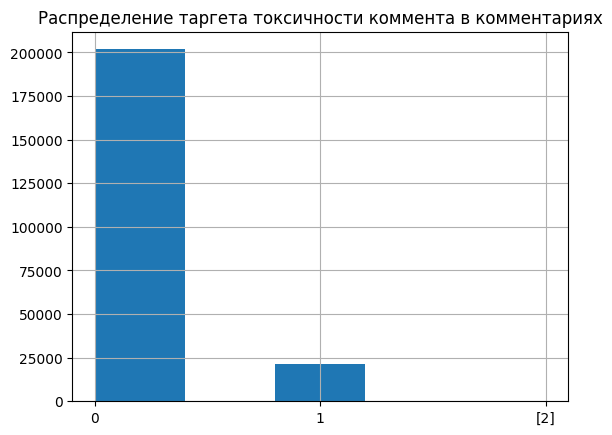

In [13]:
pd.Series(data['toxic']).hist( bins = 5)
plt.title('Распределение таргета токсичности коммента в комментариях')
plt.show()

Дисбаланс классов. Поработаем над весами позже

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     223549 non-null  int64 
 1   id             223549 non-null  object
 2   comment_text   223147 non-null  object
 3   toxic          223549 non-null  object
 4   severe_toxic   223549 non-null  int64 
 5   obscene        223549 non-null  int64 
 6   threat         223549 non-null  int64 
 7   insult         223549 non-null  int64 
 8   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 15.4+ MB


In [53]:
data = data.dropna(subset = 'comment_text')

In [54]:
data['toxic'].value_counts()

toxic
0    201785
1     21362
Name: count, dtype: int64

## Бэйзлайн модель

In [55]:
text_features = ['comment_text'   ]

In [56]:
y = data['toxic']

In [57]:
X = data.drop(['toxic','id'], axis = 1)

In [58]:
X = data.drop(['toxic','id'], axis = 1)
X[text_features] = X[text_features].fillna('tbd')
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )
print(data.shape), print(test_x.shape), print(test_x.shape),

In [59]:
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )

In [60]:
print(data.shape), print(test_x.shape), print(test_x.shape),

(223147, 9)
(55787, 7)
(55787, 7)


(None, None, None)

In [62]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='Logloss',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
                                
)


model_cb.fit(train_x, train_y, text_features=text_features, plot= True)


ERROR! Session/line number was not unique in database. History logging moved to new session 313


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [64]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train[:,1], multi_class='ovr')
auc_test = roc_auc_score(test_y, proba_test[:,1], multi_class='ovr')
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)
mse = mean_squared_error(test_y, test_pred)
rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97     50463
           1       0.77      0.51      0.62      5324

    accuracy                           0.94     55787
   macro avg       0.86      0.75      0.79     55787
weighted avg       0.93      0.94      0.93     55787


Confusion Matrix

[[49654   809]
 [ 2594  2730]]
AUC ROC train:  0.9495036877950283
AUC ROC test:  0.9240930169947101
Root Mean Squared Error на тестовой выборке: 0.24698152668314743
Mean Absolute Error на тестовой выборке: 0.06099987452273827
R2 на тестовой выборке: 0.2933833862966866


In [85]:
data['comment_text'].head()

0    D'Оо! Он соответствует этому цвету фона, с кот...
1    "\n\nПоздравляю и меня, хорошо использую инстр...
2    Смысл Mitsurugi не имеет смысла - почему бы не...
3    О, и девушка выше начала свои споры со мной. О...
4    До свидания!\nНе смотри, приходи или думай о в...
Name: comment_text, dtype: object

## Стоп-слова и пунктуация

In [86]:
data['comment_text'] = data['comment_text'].str.replace('\n', '')


In [87]:
data['comment_text'].head()

0    D'Оо! Он соответствует этому цвету фона, с кот...
1    "Поздравляю и меня, хорошо использую инструмен...
2    Смысл Mitsurugi не имеет смысла - почему бы не...
3    О, и девушка выше начала свои споры со мной. О...
4    До свидания!Не смотри, приходи или думай о воз...
Name: comment_text, dtype: object

In [88]:
regex = re.compile("[А-ЯЁа-яёA-Za-z!]+")

def get_rus_words_only(row, regex=regex):
    try:
        return " ".join(regex.findall(row['comment_text']))
    except:
        return ""


In [89]:
data['only_text'] = data.apply(get_rus_words_only, axis = 1)
data['only_text'].head()

0    D Оо! Он соответствует этому цвету фона с кото...
1    Поздравляю и меня хорошо использую инструменты...
2    Смысл Mitsurugi не имеет смысла почему бы не п...
3    О и девушка выше начала свои споры со мной Она...
4    До свидания!Не смотри приходи или думай о возв...
Name: only_text, dtype: object

In [73]:
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [74]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
excl_list = ['хорошо', 'не', 'никогда','ничего', "!", 'нельзя' ]

In [76]:
noise = stopwords.words('russian') + list(punctuation)+ ['``', "''",'--',"//", '/']
len(noise)


188

In [77]:
noise = [x for x in noise if x not in  excl_list]
len(noise)

182

In [91]:
data.columns

Index(['Unnamed: 0', 'id', 'comment_text', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate', 'only_text'],
      dtype='object')

In [95]:
X = data.drop(['Unnamed: 0', 'id', 'comment_text', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate', ], axis = 1)
X.head()

,only_text
0,D Оо! Он соответствует этому цвету фона с кото...
1,Поздравляю и меня хорошо использую инструменты...
2,Смысл Mitsurugi не имеет смысла почему бы не п...
3,О и девушка выше начала свои споры со мной Она...
4,До свидания!Не смотри приходи или думай о возв...


In [96]:
text_features = ['only_text']
X[text_features] = X[text_features].fillna('tbd')
train_x, test_x, train_y, test_y = train_test_split(X, y,
                                                   test_size=TEST_SIZE, random_state=RS,
                                                   )
print(data.shape), print(test_x.shape), print(test_x.shape),

(223147, 10)
(55787, 1)
(55787, 1)


(None, None, None)

In [97]:
model_cb = CatBoostClassifier(iterations=1689,
                                depth = 6,
                                loss_function='Logloss',
                                thread_count=-1, 
                                random_seed=RANDOM_STATE, 
                                verbose=0, 
                                text_features=text_features,
                                task_type = "GPU" 
                                
)


model_cb.fit(train_x, train_y, text_features=text_features, plot= True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [101]:
test_pred = model_cb.predict(test_x)
proba_test = model_cb.predict_proba(test_x)

train_pred = model_cb.predict(train_x)
proba_train = model_cb.predict_proba(train_x)
 
test_pred = model_cb.predict(test_x)
confusion = confusion_matrix(test_y, test_pred)
print(CR + classification_report(test_y,test_pred)) 

print(CR + 'Confusion Matrix\n')
print(confusion)
auc_tr = roc_auc_score(train_y, proba_train[:,1])
auc_test = roc_auc_score(test_y, proba_test[:,1])
print('AUC ROC train: ',auc_tr)
print('AUC ROC test: ',auc_test)
mse = mean_squared_error(test_y, test_pred)
rmse = root_mean_squared_error(test_y, test_pred)
mae = mean_absolute_error(test_y, test_pred)
print("Root Mean Squared Error на тестовой выборке:", rmse)
print("Mean Absolute Error на тестовой выборке:", mae)
r2 = r2_score(test_y, test_pred)
print("R2 на тестовой выборке:", r2)


              precision    recall  f1-score   support

           0       0.95      0.98      0.97     50463
           1       0.77      0.56      0.65      5324

    accuracy                           0.94     55787
   macro avg       0.86      0.77      0.81     55787
weighted avg       0.94      0.94      0.94     55787


Confusion Matrix

[[49590   873]
 [ 2356  2968]]
AUC ROC train:  0.9576385292843745
AUC ROC test:  0.9380503144935001
Root Mean Squared Error на тестовой выборке: 0.24058443071539595
Mean Absolute Error на тестовой выборке: 0.057880868302651156
R2 на тестовой выборке: 0.3295136509997064


In [100]:
```
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     50463
           1       0.77      0.51      0.62      5324

    accuracy                           0.94     55787
   macro avg       0.86      0.75      0.79     55787
weighted avg       0.93      0.94      0.93     55787


Confusion Matrix

[[49654   809]
 [ 2594  2730]]
AUC ROC train:  0.9495036877950283
AUC ROC test:  0.9240930169947101
Root Mean Squared Error на тестовой выборке: 0.24698152668314743
Mean Absolute Error на тестовой выборке: 0.06099987452273827
R2 на тестовой выборке: 0.2933833862966866
    ```

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)